# Listening to LIGO auxiliary data

We will download some noise-monitoring data from LIGO and play it as a sound.

(The following two cells of code are preliminaries which you can skip.)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from gwpy.timeseries import TimeSeries
import gwpy.time

## Retrieving data

Let's download some auxiliary channel data from the Gravitational Wave Open Science Center (GWOSC), following the documentation [here](https://gwosc.org/O3/auxiliary/) and the example [here](https://git.ligo.org/gwosc/tutorials/gwosc-aux-tutorials/-/blob/main/Tutorials/data_access.ipynb).

To do that, we need to specify a channel name (i.e., which sensor/recorder we want) and a stretch of time. Time in LIGO land is specified in terms of the GPS coordinate system (see, e.g., [this reference](https://www.oc.nps.edu/oc2902w/gps/timsys.html)), which is the number of seconds since 1/5/1980 to 1/6/1980 midnight (a fractional number corresponds to a fraction of a second).

In [3]:
channel_name = 'L1:ISI-GND_STS_ITMY_Z_BLRMS_30M_100M'
start_time = 1266624018
end_time = 1266624618

We can see what dates the chosen `start_time` and `end_time` correspond to using the `gwpy.time.from_gps` tool:

In [4]:
print("Start time:\t%s" % gwpy.time.from_gps(start_time).strftime('%Y-%m-%d %H:%M:%S'))
print("End time:\t%s" % gwpy.time.from_gps(end_time).strftime('%Y-%m-%d %H:%M:%S'))

Start time:	2020-02-25 00:00:00
End time:	2020-02-25 00:10:00


So the GPS times we specified above correspond to 10 minutes starting at 00:00 h on February 25, 2020.

The channel name we chose corresponds to a seismometer located in the corner station near the inner test mass of the Y-arm of the LIGO Livingston instrument (`L1`). We can see that by looking up the channel name on the list of channels [here](https://git.ligo.org/gwosc/tutorials/gwosc-aux-tutorials/-/blob/main/Channels/O3_bulk_aux_channel_list.csv); additionally, we can map out channels by looking them up in [pem.ligo.org](https://pem.ligo.org), though the list of active channels evolves and you might not find all channels there.

With all that info, we can download the data!

In [5]:
data = TimeSeries.fetch(channel_name, start=start_time, end=end_time, host='losc-nds.ligo.org')

## Plotting data

Now that we have downloaded the data, we can display it in different ways. First, in the time domain: we can show what the recording was as a function of time.

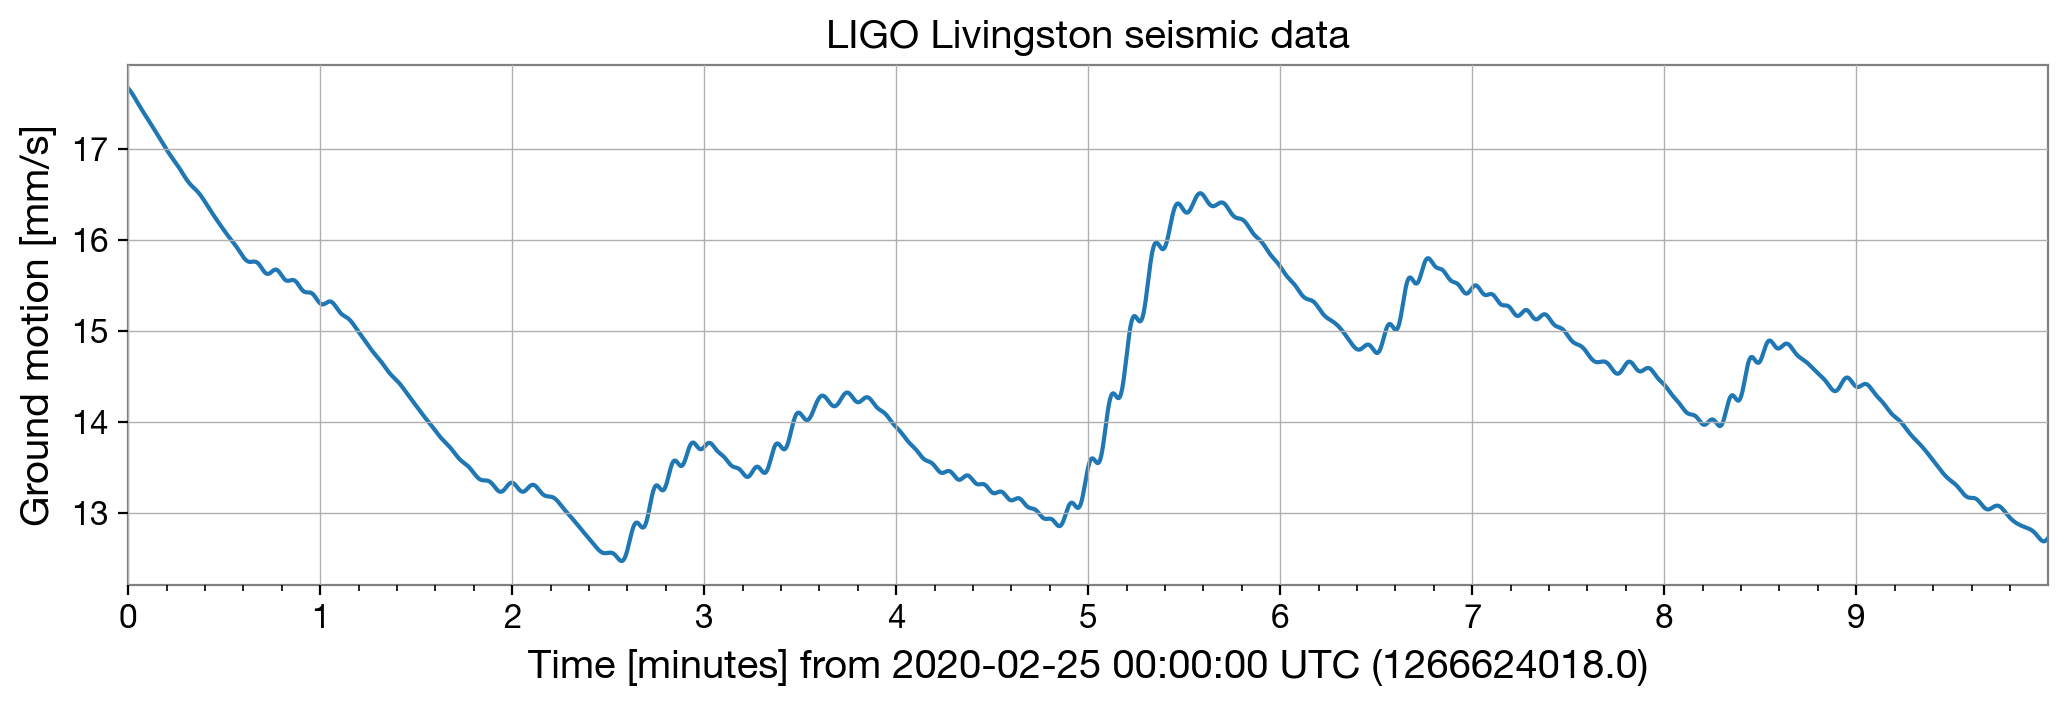

In [6]:
data.plot(ylabel="Ground motion [mm/s]", title="LIGO Livingston seismic data", epoch=start_time);

The ground motion decreases from midnight until ~2min later, then starts to rise again around 5 min from midnight. Note that the data record the instantaneous speed of ground motion and they are in units of millimeters per second.

We can look also at the same data in frequency space: is this noise white, blue (higher pitches) or red (lower pitches)?

In [7]:
data_asd = data.asd(4, 2)

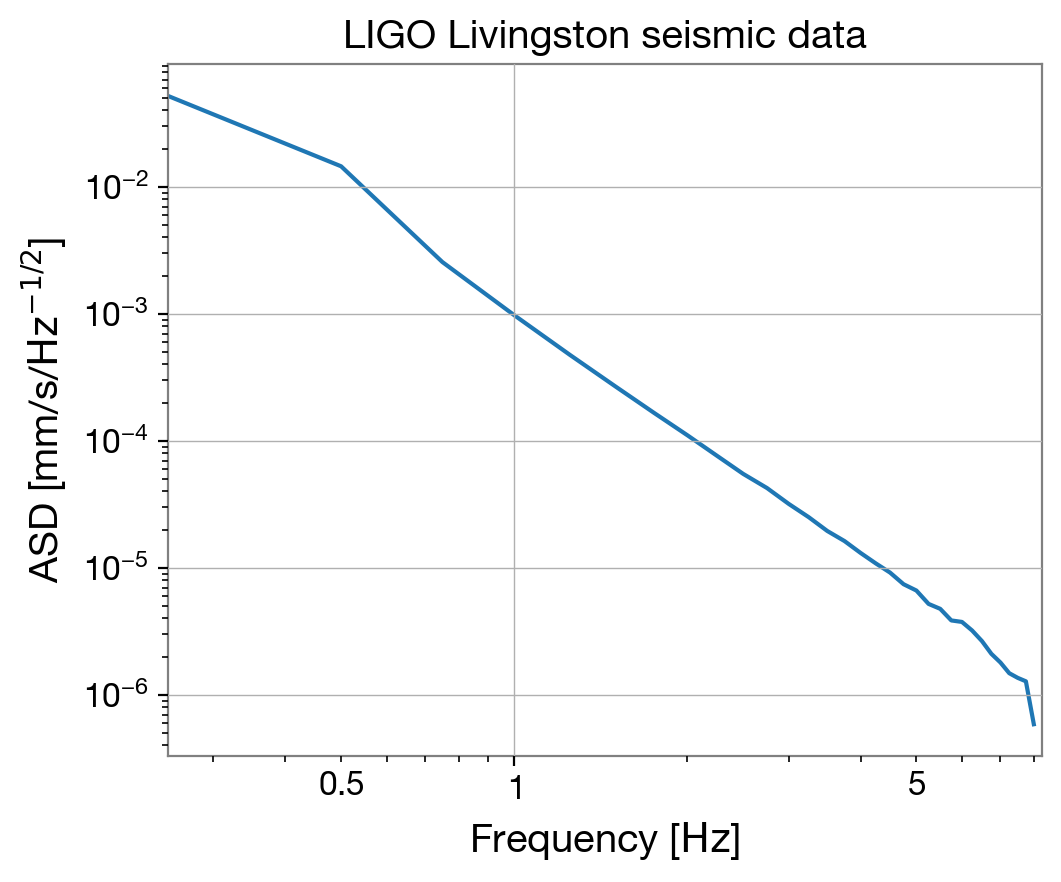

In [8]:
data_asd.plot(title="LIGO Livingston seismic data", ylabel=r"ASD [mm/s/$\mathrm{Hz}^{-1/2}$]");

These data are dominated by _low_ frequencies, below 1 Hz, which is what we expect for seismic data, since the ground usually shakes slowly.

In [13]:
specgram = data.spectrogram(2, fftlength=0.5) ** (1/2.)

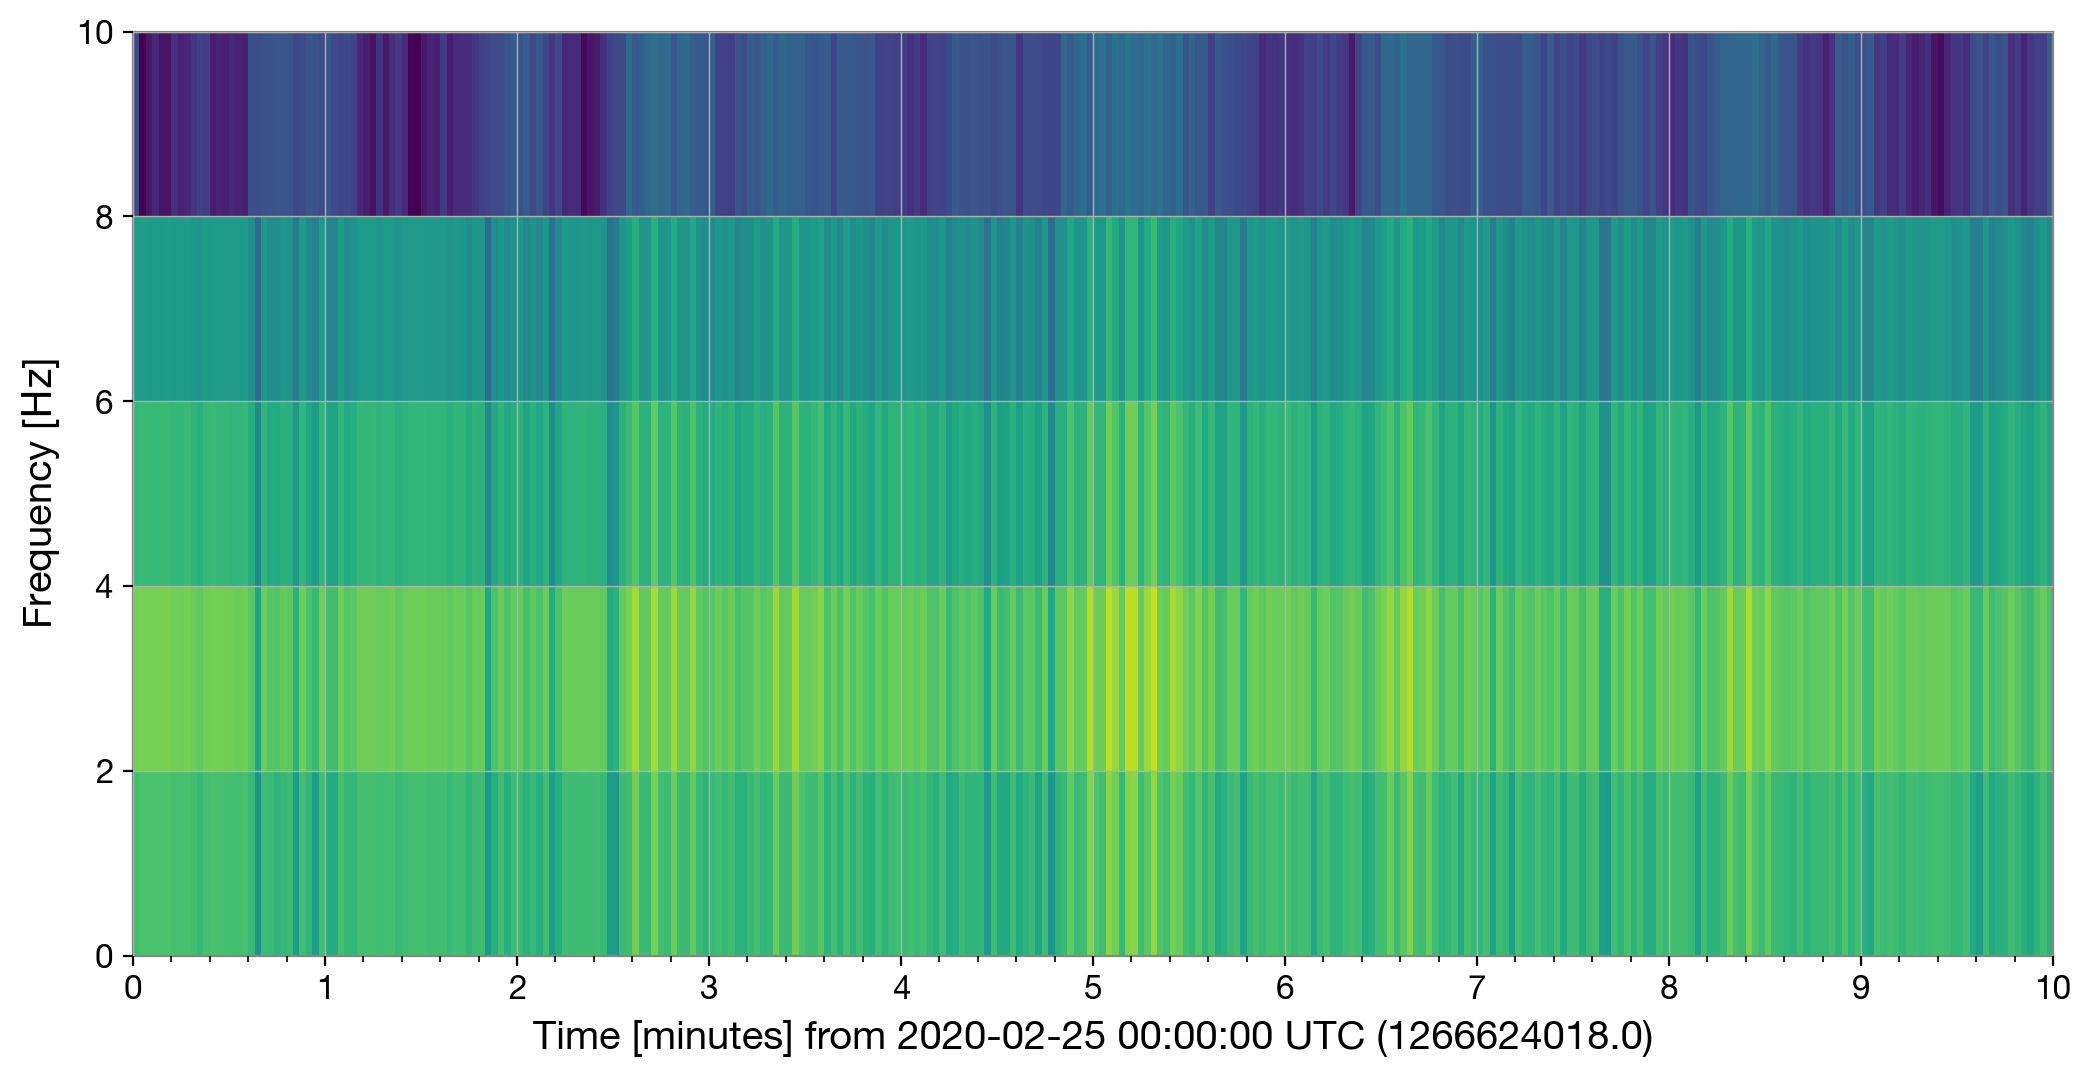

In [18]:
plot = specgram.imshow(norm='log', vmin=1e-7, vmax=0.5e-1)
# ax = plot.gca()
# ax.set_yscale('log')
# ax.set_ylim(0.1, 10)
# ax.colorbar(
#     label=r'LIGO Livingston seismic data [mm/s/$\mathrm{Hz}^{-1/2}$]')


## Play sound!

In [19]:
import wave

In [26]:
data.value

array([17.668596, 17.666243, 17.663837, ..., 12.724274,
       12.727328, 12.730474], dtype=float32)

In [25]:
# sampling rate of data in Hz
fs = data.sample_rate.value

In [31]:
max_16bit = 32767
int_data = [int(sample * max_16bit / max(data.value)) for sample in data.value]

# Convert integer data to byte string
byte_data = b''.join((sample).to_bytes(2, 'little', signed=True) for sample in int_data)

In [32]:
with wave.open('output.wav', 'wb') as wf:
    wf.setnchannels(1)  # mono
    wf.setsampwidth(2)  # 2 bytes or 16-bit
    wf.setframerate(fs)
    wf.writeframes(byte_data)